## Compare Step-Index computations

### Imports

In [8]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from scipy.io import savemat

import gc
import os
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

from mmfsim.phase import LinearPhase
from mmfsim.grid import Grid
from mmfsim.fiber import StepIndexFiber
from mmfsim.beams import GaussianBeam
from mmfsim.coupling import StepIndexFiberDegenCoupler
from mmfsim.speckle import DegenStepIndexSpeckle
from mmfsim.transforms import fourier_transform
from mmfsim.devices import MockDeformableMirror

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simulation variables

In [2]:
fiber_radius = 25e-6
fiber_length = 1e0
power_n = 7
power_n_fourier = 11
grid_length_fourier = 2 ** power_n_fourier
grid_length = 2 ** power_n
grid_size = 2 * fiber_radius
pixel_size = grid_size / grid_length

fiber_kwargs = dict(radius=fiber_radius, wavelength=1064e-9, n1=1.4665, n2=1.45)
grid_kwargs = dict(pixel_size=pixel_size, pixel_numbers=(grid_length, grid_length))

### Define the fiber

In [3]:
grid = Grid(**grid_kwargs)
fiber = StepIndexFiber(**fiber_kwargs)
print(fiber)

c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:247: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v**2 - u**2)
c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:248: RuntimeWarning: invalid value encountered in divide
  return sp.jv(n, u) / (u * sp.jv(n - 1, u)) + sp.kn(n, w) / (w * sp.kn(n - 1, w))


StepIndexFiber instance with:
  - Radius: 25.0 um
  - Core index: 1.4665
  - Cladding index: 1.45
  - Wavelength: 1064.0 nm
  - Numerical aperture: 0.219
  - Number of guided LP modes: 140
  - Number of guided LP modes (counting degenerates): 269
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[ 1.46641487  0.          0.          1.        ]
 [ 1.46628389  2.          1.          1.        ]
 [ 1.46611179  4.          2.          1.        ]
 [ 1.46605151  1.          0.          2.        ]
 [ 1.46590084  6.          3.          1.        ]
 [ 1.46577563  3.          1.          2.        ]
 [ 1.46565244  8.          4.          1.        ]
 [ 1.46545734  5.          2.          2.        ]
 [ 1.46539799  2.          0.          3.        ]
 [ 1.46536754 10.          5.          1.        ]]


In [4]:
fiber.compute_modes_fields(grid)
clear_output(wait=False)

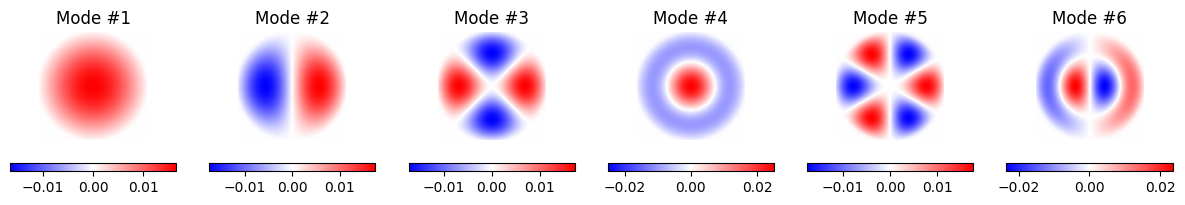

In [5]:
plt.figure(figsize=(15, 2))

max_modes = 6

for i in range(max_modes):
    plt.subplot(1, max_modes, i+1)
    mode = fiber._modes[:, :, 0, i]
    plt.imshow(mode, cmap='bwr', vmin=-np.max(np.abs(mode)), vmax=+np.max(np.abs(mode)))
    plt.axis('off')
    plt.title(f'Mode #{i+1}')
    plt.colorbar(orientation='horizontal')

### Define fitness and helpful functions

In [176]:
from waveoptics.metrics.numpy import quality, pearson
from waveoptics.plots.plots import complex_to_hsv

import torch
from torch.nn import AdaptiveAvgPool2d, UpsamplingNearest2d


class ModalModeController:

    def __init__(self, n_control_modes, dm_1d_acts, grid, target_field: np.ndarray, mode_index: int, fiber, fiber_length: float = 1.0, fitness_type: str = 'pearson', pad_coeff: float = 5):
        self.n_control_modes = n_control_modes
        self.dm_1d_acts = dm_1d_acts
        self.grid = grid
        self.target_field = target_field
        self.pad_coeff = pad_coeff
        self.target_fourier = self.padded_fourier(self.target_field)
        self.mode_index = mode_index
        self.fiber = fiber
        self.fiber_length = fiber_length
        self.fitness_type = fitness_type.lower()
        self.speckle = DegenStepIndexSpeckle(self.fiber, self.grid, self.n_control_modes)
        self.speckle.compose()
        self.make_diagonal_mode_coupling_matrix()
        

    def make_diagonal_mode_coupling_matrix(self) -> np.ndarray:
        prop_constants = self.fiber._prop_constants.copy() # Columns with beta, n_eff, n, m, u, w
        print(prop_constants.shape)

        degen_betas = np.zeros(shape=(self.fiber._N_modes_degen))
        k = 0
        for i in range(fiber._N_modes):
            if prop_constants[i, 2] == 0: # Mode is centro-symmetric
                degen_betas[k] = prop_constants[i, 0]
                k += 1
            else: # Mode is not centro-symmetric
                degen_betas[k] = prop_constants[i, 0]
                degen_betas[k+1] = prop_constants[i, 0]
                k += 2

        self.propagation_matrix = np.diag(np.exp(-1j * degen_betas * self.fiber_length))


    def compute_output_field(self, x_reim):
        self.dm_field = self.convert_field_to_dm(self.generate_modal_input_beam(x_reim))
        self.coupled_in = StepIndexFiberDegenCoupler(self.dm_field, self.grid, self.fiber, N_modes=self.fiber._N_modes_degen)
        self.coupled_out = self.propagate(self.coupled_in)

    def generate_modal_input_beam(self, x_reim) -> np.ndarray:
        n2 = x_reim.size
        re_coeffs = x_reim[:n2//2]
        im_coeffs = x_reim[n2//2:]
        cplx_coeffs = re_coeffs + 1j * im_coeffs
        cplx_coeffs /= np.sqrt(np.sum(np.square(np.abs(cplx_coeffs))))
        self.speckle.compose(cplx_coeffs)
        return self.speckle.field
    
    def convert_field_to_dm(self, field: np.array):
        with torch.no_grad():
            downsampler = AdaptiveAvgPool2d(output_size=(self.dm_1d_acts, self.dm_1d_acts))
            upsampler =  UpsamplingNearest2d(size=self.target_field.shape)

            downsampled = (
                downsampler(torch.from_numpy(np.real(field[np.newaxis, np.newaxis, ...])))
                + 1j * downsampler(torch.from_numpy(np.imag(field[np.newaxis, np.newaxis, ...])))
            )

            resampled = (
                upsampler(torch.real(downsampled))
                + 1j * upsampler(torch.imag(downsampled))
            )

        return resampled.squeeze().cpu().detach().numpy()
    
    def propagate(self, coupled_in) -> np.ndarray:
        new_coeffs = self.propagation_matrix @ coupled_in.modes_coeffs

        coupled_out = deepcopy(coupled_in)
        coupled_out.modes_coeffs = new_coeffs
        coupled_out.recompose()

        return coupled_out
    
    def padded_fourier(self, field):
        pad_to = self.pad_coeff * self.target_field.shape[0]
        pad_amount = (pad_to - self.target_field.shape[0]) // 2
        padded_field = np.pad(field, pad_width=pad_amount)

        fourier_field = fourier_transform(padded_field)
        win = slice(pad_amount, -pad_amount)
        fourier_field = fourier_field[win, win]
        
        return fourier_field
    

    def fitness_cplx(self, x_reim):
        self.compute_output_field(x_reim)

        if self.fitness_type == 'pearson':
            self.loss = -pearson(np.square(np.abs(self.coupled_out.field)), np.square(np.abs(self.target_field)))
        elif self.fitness_type == 'quality':
            self.loss = -quality(self.coupled_out.field / np.max(np.abs(self.coupled_out.field)), self.target_field / np.max(np.abs(self.target_field)), squared=True)
        elif self.fitness_type == 'coeff':
            self.loss = -np.square(np.abs(self.coupled_out.modes_coeffs[self.mode_index]))
        elif self.fitness_type == 'fourier':
            self.fourier_field = self.padded_fourier(self.coupled_out.field)
            self.loss = -1 * (
                0.5 * pearson(np.square(np.abs(self.coupled_out.field)), np.square(np.abs(self.target_field)))
                + 0.5 * pearson(np.square(np.abs(self.fourier_field)), np.square(np.abs(self.target_fourier)))
            )
        else:
            self.loss = -pearson(np.square(np.abs(self.coupled_out.field)), np.square(np.abs(self.target_field)))

        return self.loss
    

    def plot_results(self):
        pear = pearson(np.square(np.abs(self.coupled_out.field)), np.square(np.abs(self.target_field)))
        qual = quality(self.coupled_out.field / np.max(np.abs(self.coupled_out.field)), self.target_field / np.max(np.abs(self.target_field)))
        print(f"Best value: {self.loss}")
        print(f"Pearson intensity: {pear}")
        print(f"Quality squared: {qual}")


        plt.figure(figsize=(15, 5))

        plt.subplot(2, 6, 1)
        plt.imshow(complex_to_hsv(self.dm_field))
        plt.axis('off')
        plt.title('DM field')

        plt.subplot(2, 6, 2)
        plt.imshow(complex_to_hsv(self.coupled_in.field))
        plt.axis('off')
        plt.title('Input field')

        plt.subplot(2, 6, 3)
        plt.imshow(complex_to_hsv(self.coupled_out.field))
        plt.axis('off')
        plt.title('Output field')

        plt.subplot(2, 6, 4)
        plt.imshow(complex_to_hsv(self.target_field))
        plt.axis('off')
        plt.title('Target field')

        if self.fitness_type == 'fourier':
            plt.subplot(2, 6, 5)
            plt.imshow(complex_to_hsv(self.fourier_field))
            plt.axis('off')
            plt.title('Fourier field')

            plt.subplot(2, 6, 6)
            plt.imshow(complex_to_hsv(self.target_fourier))
            plt.axis('off')
            plt.title('Target fourier field')

        plt.subplot(2, 6, 8)
        plt.imshow(np.square(np.abs(self.coupled_in.field)), cmap='gray', vmin=0)
        plt.axis('off')
        plt.title('Input intensity')

        plt.subplot(2, 6, 9)
        plt.imshow(np.square(np.abs(self.coupled_out.field)), cmap='gray', vmin=0)
        plt.axis('off')
        plt.title('Output intensity')

        plt.subplot(2, 6, 10)
        plt.imshow(np.square(np.abs(self.target_field)), cmap='gray', vmin=0)
        plt.axis('off')
        plt.title('Target intensity')

        if self.fitness_type == 'fourier':
            plt.subplot(2, 6, 11)
            plt.imshow(np.square(np.abs(self.fourier_field)), cmap='gray', vmin=0)
            plt.axis('off')
            plt.title('Fourier intensity')

            plt.subplot(2, 6, 12)
            plt.imshow(np.square(np.abs(self.target_fourier)), cmap='gray', vmin=0)
            plt.axis('off')
            plt.title('Target fourier intensity')

        plt.tight_layout()

        self.coupled_out.show_coefficients(as_heatmap=True)



### Optimize using CMA-ES from Nevergrad

(140, 6)


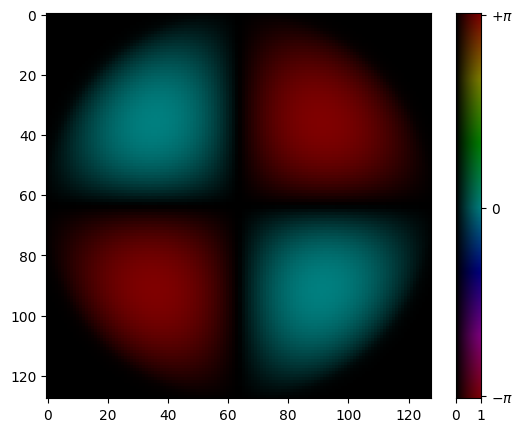

In [184]:
from waveoptics.plots.plots import complex_imshow
from scipy.ndimage import gaussian_filter

n_modes = 10
n_dm = 64
mode_index = 2
target_field = np.complex64(fiber._modes[:, :, 1, mode_index])
complex_imshow(target_field)

controller = ModalModeController(
    n_control_modes=n_modes,
    dm_1d_acts=n_dm,
    grid=grid,
    target_field=target_field,
    mode_index=mode_index,
    fiber=fiber,
    fiber_length=1000.0,
    fitness_type='fourier',
    pad_coeff=5,
)

In [185]:
import cma

x0 = np.random.rand(n_modes) * np.exp(1j * 2 * np.pi * np.random.rand(n_modes))
x0 /= np.sqrt(np.sum(np.square(np.abs(x0))))
x0 = np.concatenate([np.real(x0), np.imag(x0)])
ub = 1.0
lb = -1.0

es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=1/8,
    options={
        'bounds': [lb, ub],
        # 'popsize': 20,
    },
)

es.optimize(controller.fitness_cplx, iterations=20)
# Get best solution and show it
best_solution = es.result.xbest 
best_value = es.result.fbest
best_eval = es.result.evals_best
fevals = es.result.evaluations

print(f"fevals={fevals}, best_value={best_value}, best_eval={best_eval}")

# plt.imshow(np.square(get_amplitude_from_phases(best_solution, TM, m)))

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 20 (seed=201311, Mon May 12 18:07:42 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 -4.427271735175704e-01 1.0e+00 1.18e-01  1e-01  1e-01 0:02.4
    2     24 -4.561344517216010e-01 1.1e+00 1.18e-01  1e-01  1e-01 0:04.8
    3     36 -4.964225133479723e-01 1.2e+00 1.21e-01  1e-01  1e-01 0:07.3
    5     60 -6.094259604026369e-01 1.3e+00 1.41e-01  1e-01  2e-01 0:12.2
    7     84 -6.742725320267220e-01 1.4e+00 1.67e-01  2e-01  2e-01 0:17.0
   10    120 -6.933996138269876e-01 1.5e+00 1.87e-01  2e-01  2e-01 0:24.3
   13    156 -7.392732385910552e-01 1.6e+00 2.02e-01  2e-01  2e-01 0:31.7
   16    192 -7.869070197746579e-01 1.6e+00 2.08e-01  2e-01  2e-01 0:38.9
   20    240 -7.612375146284551e-01 1.6e+00 1.97e-01  2e-01  2e-01 0:48.7
fevals=240, best_value=-0.7869070197746579, best_eval=183


Best value: -0.7869070197746579
Pearson intensity: 0.8269161354990456
Quality squared: 0.5601343951524678


c:\users\saucourt\coding\mmf_lp_modes\mmfsim\speckle.py:383: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_fmt = pivot.applymap(lambda x: f"{x:.1e}" if pd.notnull(x) else "")


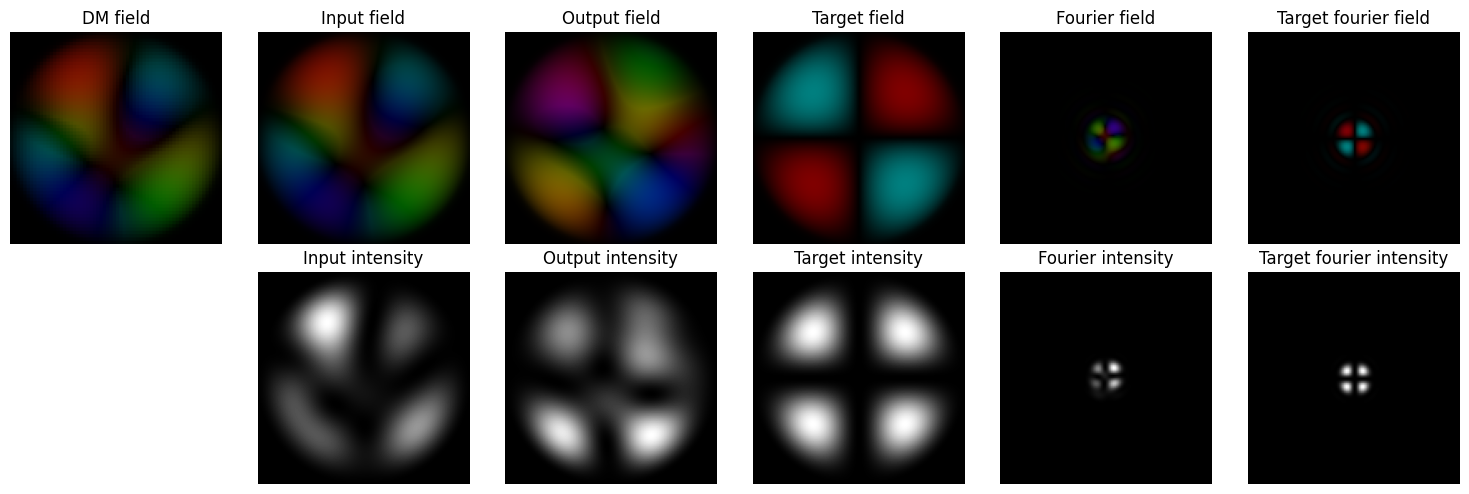

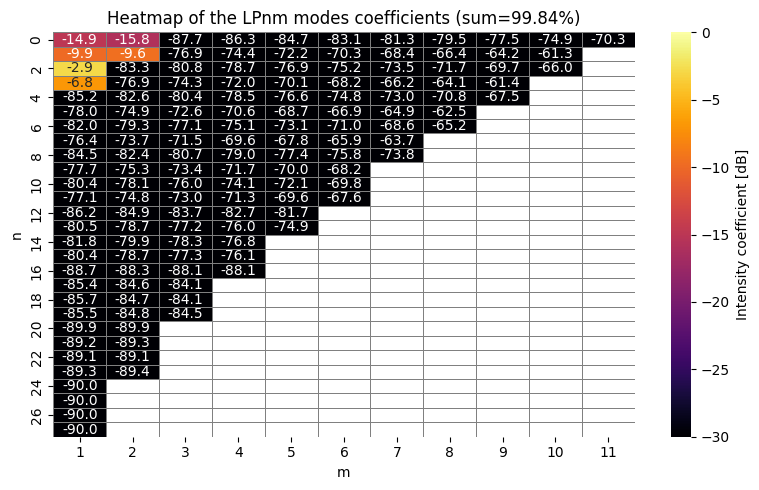

In [186]:
controller.fitness_cplx(x_reim=best_solution)
controller.plot_results()

In [166]:
es = cma.CMAEvolutionStrategy(
    x0=best_solution,
    sigma0=1/8,
    options={
        'bounds': [lb, ub],
        # 'popsize': 20,
    },
)

es.optimize(controller.fitness_cplx, iterations=80)
# Get best solution and show it
best_solution = es.result.xbest 
best_value = es.result.fbest
best_eval = es.result.evals_best
fevals = es.result.evaluations

print(f"fevals={fevals}, best_value={best_value}, best_eval={best_eval}")

(7_w,15)-aCMA-ES (mu_w=4.5,w_1=34%) in dimension 40 (seed=134984, Mon May 12 17:57:00 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -8.677730937615914e-01 1.0e+00 1.16e-01  1e-01  1e-01 0:03.1
    2     30 -8.483019925021574e-01 1.0e+00 1.11e-01  1e-01  1e-01 0:06.2
    3     45 -8.526394287127250e-01 1.1e+00 1.08e-01  1e-01  1e-01 0:09.2
    4     60 -8.641250545985565e-01 1.1e+00 1.04e-01  1e-01  1e-01 0:12.2
    6     90 -8.757040974725168e-01 1.1e+00 9.96e-02  1e-01  1e-01 0:18.3
    8    120 -8.666777788496733e-01 1.1e+00 9.60e-02  9e-02  1e-01 0:24.4
   10    150 -8.828726809720544e-01 1.1e+00 8.95e-02  9e-02  9e-02 0:30.5
   13    195 -8.944895152308676e-01 1.2e+00 8.19e-02  8e-02  8e-02 0:39.8
   16    240 -9.099085127977988e-01 1.2e+00 7.75e-02  7e-02  8e-02 0:49.1
   19    285 -9.084120465127119e-01 1.2e+00 7.00e-02  7e-02  7e-02 0:58.3
   23    345 -9.189251690514775e-01 1.2e+00 5.85e-02  6e-02  6e-02 1:10.5
   27    405 -9.319660

Best value: -0.9946967340761186
Pearson intensity: 0.9918547693435199
Quality squared: 0.9180189403081999


c:\users\saucourt\coding\mmf_lp_modes\mmfsim\speckle.py:383: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_fmt = pivot.applymap(lambda x: f"{x:.1e}" if pd.notnull(x) else "")


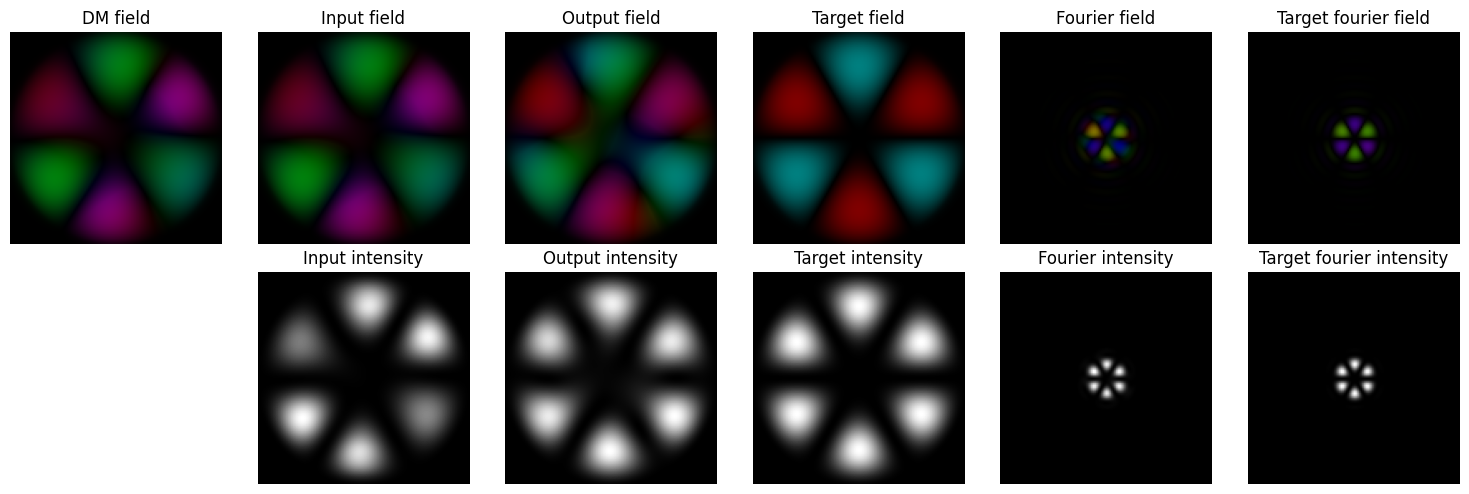

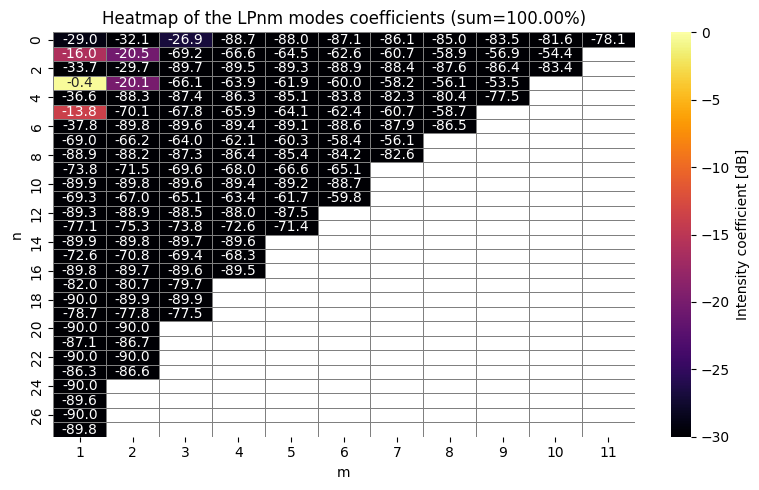

In [168]:
controller.fitness_cplx(x_reim=best_solution)
controller.plot_results()